In [ ]:
!pip install ultralytics -q
!pip install gradio -q
!pip install pandas -q
!pip install deepface -q
!pip install pillow -q
!pip install opencv-python -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 755.1/755.1 kB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.2/12.2 MB 52.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.0/92.0 kB 9.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 314.4/314.4 kB 25.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 469.9 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 142.7/142.7 kB 11.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.8/8.8 MB 54.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.2/47.2 kB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.8/60.8 kB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.9/129.9 kB 13.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 5.7 MB/

In [ ]:
!unzip /content/attendancesystem.zip

Archive:  /content/attendancesystem.zip
   creating: attendancesystem/
   creating: attendancesystem/.ipynb_checkpoints/
  inflating: attendancesystem/.ipynb_checkpoints/requirements-checkpoint.txt  
  inflating: attendancesystem/.ipynb_checkpoints/test-01-checkpoint.ipynb  
  inflating: attendancesystem/.ipynb_checkpoints/Untitled-checkpoint.ipynb  
  inflating: attendancesystem/best.pt  
  inflating: attendancesystem/classroom3.jpg  
   creating: attendancesystem/database/
   creating: attendancesystem/database/60009210123/
  inflating: attendancesystem/database/60009210123/1.jpg  
  inflating: attendancesystem/database/60009210123/10.jpg  
  inflating: attendancesystem/database/60009210123/2.jpg  
  inflating: attendancesystem/database/60009210123/3.jpg  
  inflating: attendancesystem/database/60009210123/4.jpg  
  inflating: attendancesystem/database/60009210123/5.jpg  
  inflating: attendancesystem/database/60009210123/6.jpg  
  inflating: attendancesystem/database/60009210123/7.j

In [ ]:
# Import necessary libraries
from ultralytics import YOLO
from ultralytics.engine.results import Results
from deepface import DeepFace
from PIL import Image
import gradio as gr
import shutil
import pandas
import cv2
import os

24-05-03 09:07:13 - Directory /root/.deepface created
24-05-03 09:07:13 - Directory /root/.deepface/weights created


In [ ]:
def faceRecognition(input_image):
    # Path to the directory containing cropped objects
    cropped_objects_dir = "/content/faces"

    # Initialize lists to store the extracted names and predicted image filenames
    extracted_names = []
    predicted_image_filenames = []

    file_to_delete = "./database/representations_VGG-Face.pkl"
    if os.path.exists(file_to_delete):
        os.remove(file_to_delete)

    # Iterate through the image files in the directory
    for filename in os.listdir(cropped_objects_dir):
        if filename.endswith(".jpg"):
            img_path = os.path.join(cropped_objects_dir, filename)
            model = DeepFace.find(img_path=img_path, db_path="/content/attendancesystem/database", enforce_detection=False, model_name="VGG-Face")

            # Check if a face was recognized in the image
            if model and len(model[0]['identity']) > 0:
                # Extract the name and append it to the list
                name = model[0]['identity'][0].split('/')[4]
                extracted_names.append(name)
                # Append the predicted image filename to the list
                predicted_image_filenames.append(filename)
            else:
                # If no face is recognized, set name to 'unknown'
                name = 'unknown'
                extracted_names.append(name)
                # Append the predicted image filename to the list
                predicted_image_filenames.append(filename)

    return extracted_names, predicted_image_filenames


In [ ]:
def faceExtraction(input_image, model, results):
    # Load the image
    image = input_image

    detected_faces = []

    if results:
        for result in results:
            x, y, width, height = result['box']
            x1, y1, x2, y2 = x, y, x + width, y + height
            detected_faces.append(('face', (x1, y1, x2, y2)))

    # Create or clear the 'faces' directory
    if os.path.exists("faces"):
        shutil.rmtree("faces")
    os.makedirs("faces")

    # Crop and save each detected face
    for i, (object_name, (x1, y1, x2, y2)) in enumerate(detected_faces):
        face_image = image[y1:y2, x1:x2]
        cv2.imwrite(f"faces/face{i}.jpg", face_image)

    return detected_faces

In [ ]:
import cv2
from mtcnn import MTCNN

def faceDetection(image_path):
    # Load the input image using OpenCV
    input_image = cv2.imread(image_path)

    if input_image is None:
        print("Error: Unable to load the input image.")
        return

    # Create an instance of the MTCNN detector
    detector_mtcnn = MTCNN()

    # Detect faces in the input image
    results = detector_mtcnn.detect_faces(input_image)

    return faceExtraction(input_image, detector_mtcnn, results)

# Rest of the code remains the same


In [ ]:
image = input("enter image path : ")
faceDetection(image)
names, image = faceRecognition(image)
print(names)
print(image)

enter image path : /content/attendancesystem/classroom3.jpg
5/5 [==============================] - 1s 49ms/step
24-05-03 09:10:55 - Found 400 newly added image(s), 0 removed image(s), 0 replaced image(s).


Finding representations:   0%|          | 0/400 [00:00<?, ?it/s]

24-05-03 09:10:58 - vgg_face_weights.h5 will be downloaded...


Downloading...
From: https://github.com/serengil/deepface_models/releases/download/v1.0/vgg_face_weights.h5
To: /root/.deepface/weights/vgg_face_weights.h5

  0%|          | 0.00/580M [00:00<?, ?B/s]
  0%|          | 1.57M/580M [00:00<00:39, 14.6MB/s]
  1%|          | 4.19M/580M [00:00<00:27, 21.1MB/s]
  1%|▏         | 8.39M/580M [00:00<00:19, 29.7MB/s]
  3%|▎         | 14.7M/580M [00:00<00:13, 42.0MB/s]
  4%|▍         | 24.6M/580M [00:00<00:09, 61.3MB/s]
  7%|▋         | 39.3M/580M [00:00<00:06, 89.2MB/s]
 10%|█         | 60.3M/580M [00:00<00:04, 128MB/s] 
 15%|█▍        | 84.4M/580M [00:00<00:03, 163MB/s]
 19%|█▊        | 108M/580M [00:00<00:02, 185MB/s] 
 22%|██▏       | 127M/580M [00:01<00:02, 180MB/s]
 25%|██▌       | 148M/580M [00:01<00:02, 188MB/s]
 29%|██▉       | 167M/580M [00:01<00:02, 186MB/s]
 33%|███▎      | 190M/580M [00:01<00:01, 199MB/s]
 37%|███▋      | 212M/580M [00:01<00:01, 203MB/s]
 40%|████      | 232M/580M [00:01<00:01, 203MB/s]
 44%|████▎     | 253M/580M [00:04<

24-05-03 09:16:41 - There are now 400 representations in ds_model_vggface_detector_opencv_aligned_normalization_base_expand_0.pkl
24-05-03 09:16:41 - Searching /content/faces/face12.jpg in 400 length datastore
24-05-03 09:16:42 - find function duration 347.00903725624084 seconds
24-05-03 09:16:42 - Searching /content/faces/face17.jpg in 400 length datastore
24-05-03 09:16:43 - find function duration 1.0144984722137451 seconds
24-05-03 09:16:44 - Searching /content/faces/face19.jpg in 400 length datastore
24-05-03 09:16:45 - find function duration 1.286864995956421 seconds
24-05-03 09:16:45 - Searching /content/faces/face8.jpg in 400 length datastore
24-05-03 09:16:46 - find function duration 1.669921875 seconds
24-05-03 09:16:47 - Searching /content/faces/face14.jpg in 400 length datastore
24-05-03 09:16:48 - find function duration 1.1282072067260742 seconds
24-05-03 09:16:48 - Searching /content/faces/face28.jpg in 400 length datastore
24-05-03 09:16:49 - find function duration 1.0130

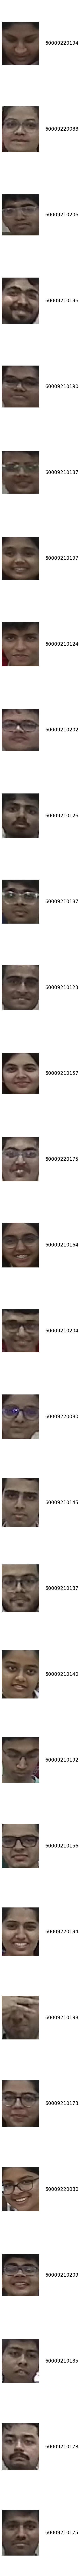

In [ ]:
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

def plot_predicted_images(image_list, names, folder_path):
    num_images = len(image_list)

    # Create a grid of subplots with two columns
    fig, axes = plt.subplots(num_images, 2, figsize=(5, 5*num_images))

    # Iterate over images and corresponding names
    for i, (image_name, predicted_label) in enumerate(zip(image_list, names)):
        # Load and plot image
        img_path = os.path.join(folder_path, image_name)
        img = mpimg.imread(img_path)
        axes[i, 0].imshow(img)
        axes[i, 0].axis('off')

        # Set title as the predicted label
        axes[i, 1].text(0.5, 0.5, predicted_label, fontsize=20, ha='center', va='center')

        # Remove axis from the label subplot
        axes[i, 1].axis('off')

    plt.tight_layout()  # Adjust spacing between subplots
    plt.show()

# Example usage
image_list = image

folder_path = '/content/faces'

# Plot predicted images
plot_predicted_images(image_list, names, folder_path)
